In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, classification_report
import textwrap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from imblearn.over_sampling import SMOTENC, SMOTE#, make_pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
print(fileloc_data)
#############################################
df_main=pd.read_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',')
print(df_main.columns)
print(df_main['pid'].nunique(), df_main['intid'].nunique())
df_main.head(3)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
Index(['intid', 'seq_num-edeq', 'EDEQscore', 'pid', 'p_startdate',
       'p_dischargedate', 'age', 'bsex', 'edu_level', 'edu_comp',
       'Highest_Edu', 'EDtype', 'icd9_code', 'icd9_lab', 'BMI', 'IND_anders',
       'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
       'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
       'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation',
       'leeftijd_invullen', 'p_dectool_invultijd', 'seq_num-dec',
       'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde', 'Split'],
      dtype='object')
298 300


,intid,seq_num-edeq,EDEQscore,pid,p_startdate,p_dischargedate,age,bsex,edu_level,edu_comp,...,andere_comorbiditeiten,duur_stoornis_in_jaren,interpretation,leeftijd_invullen,p_dectool_invultijd,seq_num-dec,uitslag_waarde,verstoord_eetpatroon,volgorde,Split
0,1491.0,1,4.76,0,2143-03-08 00:00:00,NaN,47,Vrouw,"HAVO, HBS, VWO, Atheneum. Gymnasium of MBO (MT...",MBOHAVOVWO,...,vermoeden van persoonlijkheidsprobl.,25,Geïndiceerd voor hoogspecialistische zorg op b...,47,2142-12-14 00:00:00,1,3,NaN,1,Train
1,1315.0,1,4.62,4,2142-01-21 00:00:00,2142-10-03 00:00:00,19,Vrouw,"HAVO, HBS, VWO, Atheneum. Gymnasium of MBO (MT...",MBOHAVOVWO,...,NaN,NaN,Geïndiceerd voor hoogspecialistische zorg op b...,19,2141-12-22 13:26:28,1,3,NaN,1,Train
2,1192.0,1,2.89,6,2141-09-20 00:00:00,2142-06-17 00:00:00,50,Vrouw,Lager onderwijs / lager Vormend Onderwijs / La...,LBO,...,"burnout, verslavingsgevoeligheid",30,Geïndiceerd voor hoogspecialistische zorg op b...,50,2141-05-06 16:03:35,1,4,Frequente eetbuien + braken.,1,Train


In [2]:
df_dec_mhcsf_sq48=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
print(df_dec_mhcsf_sq48['pid'].nunique(),df_dec_mhcsf_sq48['intid'].nunique())
pid_per_intid=df_dec_mhcsf_sq48['pid'].value_counts()
#print(pid_per_intid)
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])
#df_dec_mhcsf_sq48[['Split', 'intid', 'pid', 'EDtype']].loc[df_dec_mhcsf_sq48['pid'].astype(float).isin([461.0,530.0])]
#df_dectool_first.head(4)

294 296
PIDs repeated in INTIDs:  pid
461    2
530    2
Name: count, dtype: int64


In [3]:
print(df_dec_mhcsf_sq48.columns)
colsMain=['age','bsex','Highest_Edu','BMI', 'IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
    'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar', 'IND_eerdere_spec_behandeling_zonder_effect', 
    'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI', 'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
    'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation', 'leeftijd_invullen','uitslag_waarde', 
    'verstoord_eetpatroon', 'volgorde', 'Split', 'EDEQscore','EDtype']
colsMHSCF_SQ48=['age', 'bsex', 'BMI', 'Highest_Edu', 'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten','Depressie',
    'Somatische_Klachten', 'Sociale_Fobie', 'Vitaliteit_Optimisme', 'Werk_Studie', 'IND_anders','IND_as_I_II_comorbiditeiten',
    'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit','IND_duur_stoornis_2plus_jaar', 
    'IND_eerdere_spec_behandeling_zonder_effect','IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
    'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'andere_comorbiditeiten', 'duur_stoornis_in_jaren',
    'leeftijd_invullen', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB', 
    'SocialWB', 'mhcsf_score','SQ48score', 'EDEQscore', 'Split', 'EDtype']

df_dec_mhcsf_sq48[['IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar','IND_eerdere_spec_behandeling_zonder_effect', 'IND_ernstig_verstoord_eten', 
       'IND_extreem_laag_hoog_BMI','IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten','verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB']].head(4)

Index(['pid', 'intid', 'seq_num-sq48', 'Split', 'p_sq48_filled_date',
       'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten',
       'Depressie', 'Somatische_Klachten', 'Sociale_Fobie', 'SQ48score',
       'Vitaliteit_Optimisme', 'Werk_Studie', 'BMI', 'EDEQscore', 'EDtype',
       'Highest_Edu', 'IND_anders', 'IND_as_I_II_comorbiditeiten',
       'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten', 'bsex', 'duur_stoornis_in_jaren', 'edu_level',
       'icd9_lab', 'interpretation', 'leeftijd_invullen',
       'p_dectool_invultijd', 'p_dischargedate', 'p_startdate', 'seq_num-dec',
       'seq_num-edeq', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde',
       'EmotionWB', 'PsychWB', 'SocialWB', 'mhcsf_score'

,IND_anders,IND_as_I_II_comorbiditeiten,IND_borderline_comorbiditeit,IND_depressie_comorbiditeit,IND_duur_stoornis_2plus_jaar,IND_eerdere_spec_behandeling_zonder_effect,IND_ernstig_verstoord_eten,IND_extreem_laag_hoog_BMI,IND_ocd_comorbiditeit,aantal_eerdere_trajecten,age,andere_comorbiditeiten,verstoord_eetpatroon,volgorde,EmotionWB,PsychWB
0,1,1,0,0,1,1,0,0,0,8.0,47,vermoeden van persoonlijkheidsprobl.,NaN,1,3.3,2.5
1,1,1,0,0,0,0,1,1,0,NaN,19,NaN,NaN,1,2.7,2.7
2,1,1,1,0,1,1,1,0,0,1.0,50,"burnout, verslavingsgevoeligheid",Frequente eetbuien + braken.,1,3.0,2.0
3,0,0,0,0,0,1,1,1,0,1.0,21,NaN,"Sterk restrictief, afvallen ondanks eetlijst d...",1,3.7,3.2


### Correlation Matrix of the combined datasets

In [4]:
df_Questionnaires=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
df_Questionnaires.columns
#colsMain=[ 'age', 'bsex','Highest_Edu', 'EDtype']
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 
    'IND_duur_stoornis_2plus_jaar', 'duur_stoornis_in_jaren', 'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders',
    'IND_ernstig_verstoord_eten']
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines', 'EDEQscore']
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Somscore', 'Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid', 'LAV_Score']
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie', 'SQ48score']
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB', 'mhcsf_score']

colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 
'DT-num_prev_routes', 'DT-IND_Disorder_Duration_2+Yrs', 'DT-Disorder_Duration_Yrs', 'DT-IND_I_II_CMD', 'DT-IND_depressie_CMD',
'DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others','DT-IND_VDisturbdEating', 'Honos-Somscore', 'Honos-Beperkingen',
'Honos-Functioneren', 'Honos-Gedragsproblemen', 'Honos-Symptomalogie', 'Honos-SocialeProblemen''Lav-Neg_Waardering', 
'Lav-Gebrek_Vertrouwdheid', 'Lav-Alg_Ontevredenheid', 'Lav-Score', 'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst',
'SQ48-Depressie','SQ48-Cognitieve_Complain','SQ48-Somatische_Complain', 'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme', 
'SQ48-Werk_Studie', 'SQ48-Score', 'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB', 'MHCSF-Score']  

df_Questionnaires['BMI']=df_Questionnaires['BMI'].astype(float)
df_Questionnaires['duur_stoornis_in_jaren']=df_Questionnaires['duur_stoornis_in_jaren'].astype(float)

df_train_explore=df_Questionnaires.loc[df_Questionnaires['Split']=='Train']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
df_train_explore['bsex'] = df_train_explore['bsex'].astype('category')
df_train_explore['biosex'] = df_train_explore['bsex'].cat.codes
df_train_explore['biosex']=df_train_explore['biosex'].astype(float)
df_train_explore['EDtype'] = df_train_explore['EDtype'].astype('category')
df_train_explore['ED_Codes'] = df_train_explore['EDtype'].cat.codes
df_train_explore['Highest_Edu'] = df_train_explore['Highest_Edu'].astype('category')
df_train_explore['Edu_codes'] = df_train_explore['Highest_Edu'].cat.codes
df_train_explore['Edu_codes']=df_train_explore['Edu_codes'].astype(float)
cols2consider=['age','biosex', 'Edu_codes','ED_Codes', 'EDEQscore']+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF

bsex
Vrouw    104
Man        3
Name: count, dtype: int64
EDtype
Anorexia nervosa    47
Binge-ED            19
Other ED            18
Bulimia nervosa     13
Others              10
Name: count, dtype: int64


In [7]:
np.arange(cc_df_train_explore.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

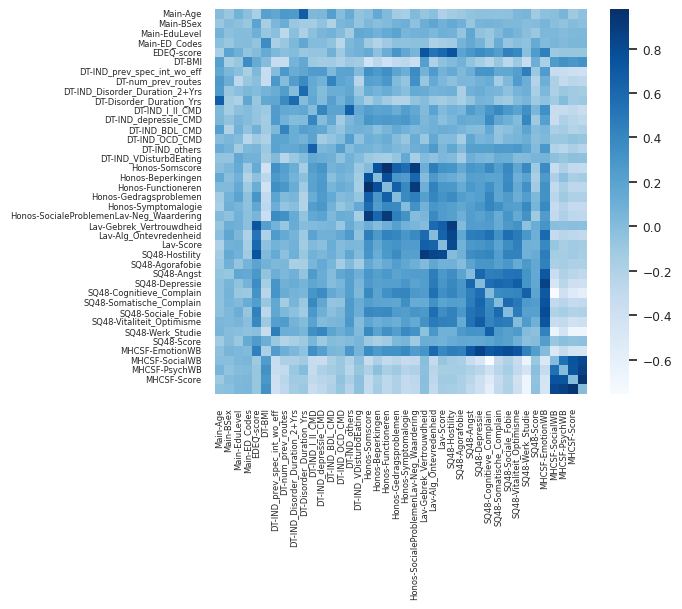

In [12]:
#df_dec_mhcsf_sq48
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
#temp_corr=cc_df_train_explore.values
#cc_df_train_explore[cc_df_train_explore.columns[np.arange(cc_df_train_explore.shape[0])]
#].iloc[[np.arange(cc_df_train_explore.shape[0])]] =0
np.fill_diagonal(cc_df_train_explore.values, 0)
#cc_df_train_explore=pd.DataFrame(temp_corr)
import seaborn as sns
fs=6
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
plt.figure(figsize=(6,5))
sns.set_style('whitegrid')
sns.set(font_scale=0.8)
g=sns.heatmap(cc_df_train_explore, cmap="Blues", annot=False, fmt=".1f", xticklabels=colNames, yticklabels=colNames)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = fs)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = fs)
plt.savefig('figs/correlationMatrix.pdf')
#cc_df_train_explore.style.background_gradient(cmap='coolwarm').set_precision(2)
#df_train_explore.columns

In [10]:
cc_df_train_explore.max()

age                                           0.674727
biosex                                        0.196135
Edu_codes                                     0.196894
ED_Codes                                      0.358000
EDEQscore                                     0.741256
BMI                                           0.358000
IND_eerdere_spec_behandeling_zonder_effect    0.459326
aantal_eerdere_trajecten                      0.423343
IND_duur_stoornis_2plus_jaar                  0.588695
duur_stoornis_in_jaren                        0.674727
IND_as_I_II_comorbiditeiten                   0.648886
IND_depressie_comorbiditeit                   0.412424
IND_borderline_comorbiditeit                  0.423343
IND_ocd_comorbiditeit                         0.228277
IND_anders                                    0.648886
IND_ernstig_verstoord_eten                    0.156608
Somscore                                      0.978046
Beperkingen                                   0.779639
Functioner

In [6]:
df_Questionnaires['Diff']=df_Questionnaires['leeftijd_invullen']-df_Questionnaires['age']
df_Questionnaires[['intid', 'pid', 'leeftijd_invullen', 'age', 'Diff']].loc[df_Questionnaires['Diff'].abs()>1]

,intid,pid,leeftijd_invullen,age,Diff
4,794,56,55,52,3
127,1119,1484,33,31,2


### Visualizing Missing Values

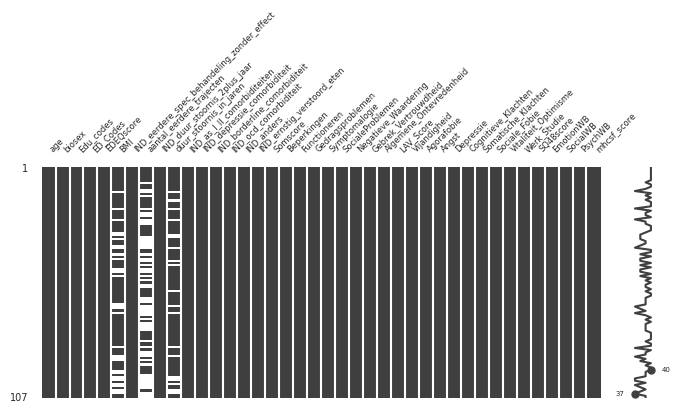

In [7]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_NaNPatterns.pdf')

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

In [10]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
cols2train=np.setdiff1d(cols2consider,['EDEQscore','ED_Codes'])
#zero_df_train=df_train_explore[cols2train].fillna(0)
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
nan_mean=np.nanmean(df_train_explore[cols2train].to_numpy(), axis=1)
nan_std=np.nanstd(df_train_explore[cols2train].to_numpy(), axis=1)
z_train_explore=((df_train_explore[cols2train].to_numpy().T-nan_mean)/nan_std).T
mask=~np.isnan(z_train_explore)
maskedarr = np.ma.array(z_train_explore, mask=~mask)
eig_val, eig_vec=np.linalg.eig(np.ma.dot(maskedarr.T, maskedarr, mask).data)
sind_eig_val=np.argsort(-1*(eig_val/np.sum(eig_val)))
evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
evd_pdist_cos=pairwise_distances(evd_z_train_explore, metric='cosine')
evd_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*evd_pdist_cos)
evd_cluster_centers_indices, evd_labels = evd_af.cluster_centers_indices_, evd_af.labels_
evd_n_clusters_ = len(evd_cluster_centers_indices)
print("Estimated number of clusters: %d" % evd_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, evd_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, evd_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, evd_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, evd_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, evd_labels))
np.fill_diagonal(evd_pdist_cos, 0)

Estimated number of clusters: 11
Homogeneity: 0.255
Completeness: 0.163
V-measure: 0.199
Adjusted Rand Index: 0.047
Adjusted Mutual Information: 0.092


Silhouette Coefficient: 0.549


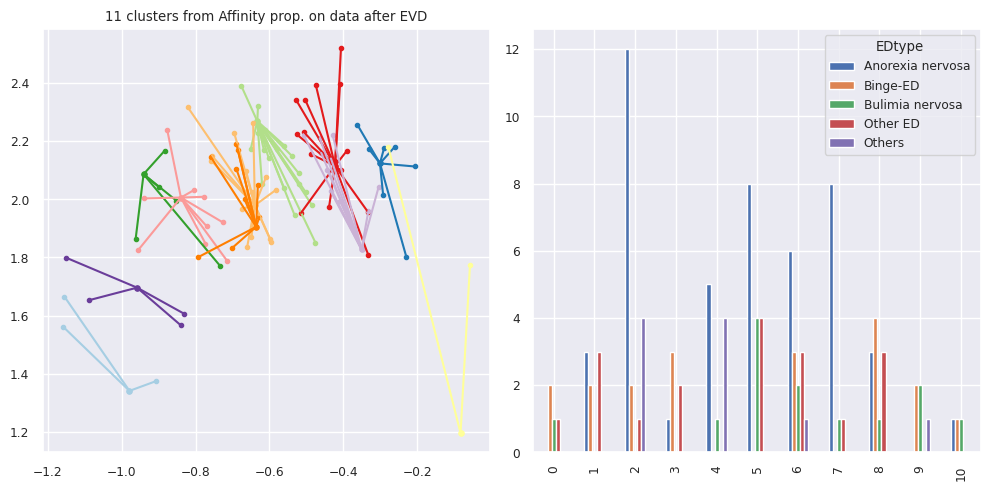

In [13]:
fig2, ax2=plt.subplots(1,2, figsize=(10,5))
colors = plt.cycler("color", plt.cm.Paired(np.linspace(0, 1, evd_n_clusters_+1)))
evd_cluster_median_profile, evd_EDtype_per_cluster={},{}
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(evd_pdist_cos, evd_labels, metric="precomputed"))
for k, col in zip(range(evd_n_clusters_), colors):
    class_members = evd_labels == k
    evd_cluster_median_profile[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    evd_cluster_median_profile[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    evd_cluster_median_profile[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    evd_EDtype_per_cluster[k]=df_train_explore['EDtype'].iloc[class_members].value_counts().sort_index()
    evd_cluster_center = evd_z_train_explore[evd_cluster_centers_indices[k]]
    ax2[0].scatter(evd_z_train_explore[class_members, 0], evd_z_train_explore[class_members, 1], 
                color=col["color"], marker=".")
    ax2[0].scatter(evd_cluster_center[0], evd_cluster_center[1], s=14, color=col["color"], marker="o")
    for x in evd_z_train_explore[class_members]:
        ax2[0].plot([evd_cluster_center[0], x[0]], [evd_cluster_center[1], x[1]], color=col["color"])

ax2[0].set_title("%d clusters from Affinity prop. on data after EVD" % evd_n_clusters_)
evd_af_cluster_df=pd.DataFrame.from_dict(evd_cluster_median_profile).T
evd_af_cluster_df.insert(0, 'Cluster',np.array(list(range(evd_n_clusters_)))+1)
evd_ed_cluster_df=pd.DataFrame.from_dict(evd_EDtype_per_cluster).T
evd_ed_cluster_df.rename(columns={'EDtype':'Cluster'}, inplace=True)
evd_ed_cluster_df.plot.bar(ax=ax2[1])
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_EVD_AP_Clustering.pdf')

In [14]:
pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_train_explore)[0]))
for i in range(np.shape(z_train_explore)[0]):
    for j in range(np.shape(z_train_explore)[0]):
        combo_mask=mask[i]& mask[j]
        temp_i, temp_j=z_train_explore[i], z_train_explore[j]
        c_tmp = np.dot(temp_i[combo_mask], temp_j[combo_mask])/(norm(temp_i[combo_mask])*norm(temp_j[combo_mask])) 
        pdist_cos[i][j] = c_tmp
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
cluster_centers_indices, labels, n_clusters_ = af.cluster_centers_indices_, af.labels_, len(af.cluster_centers_indices_)
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pdist_cos, labels, metric="precomputed"))

Estimated number of clusters: 2
Homogeneity: 0.029
Completeness: 0.173
V-measure: 0.049
Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.024
Silhouette Coefficient: -0.115


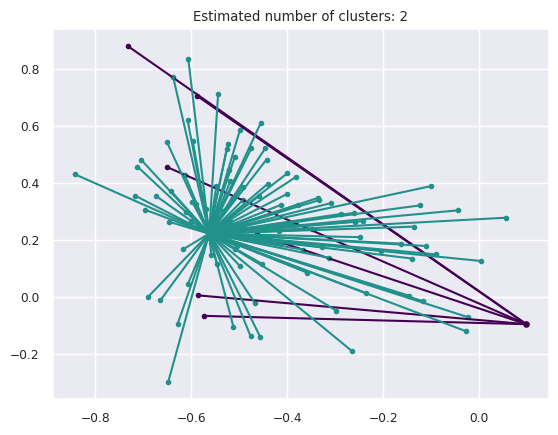

In [15]:
plt.figure(0)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_+1)))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = z_train_explore[cluster_centers_indices[k]]
    cluster_center=cluster_center[mask[cluster_centers_indices[k]]]
    plt.scatter(z_train_explore[class_members, 0], z_train_explore[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_train_explore[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [16]:
#!pip install ppca
from ppca import PPCA
ppca = PPCA()
ppca.fit(data=z_train_explore, d=3, verbose=False)
variance_explained, components, model_params  = ppca.var_exp, ppca.data, ppca.C
component_mat = ppca.transform()
ppca_pdist_cos=pairwise_distances(component_mat, metric='cosine')
ppca_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*ppca_pdist_cos)
ppca_cluster_centers_indices, ppca_labels = ppca_af.cluster_centers_indices_, ppca_af.labels_
ppca_n_clusters_ = len(ppca_cluster_centers_indices)
print("Estimated number of clusters: %d" % ppca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, ppca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, ppca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, ppca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, ppca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, ppca_labels))
np.fill_diagonal(ppca_pdist_cos, 0)

Estimated number of clusters: 11
Homogeneity: 0.218
Completeness: 0.135
V-measure: 0.167
Adjusted Rand Index: 0.031
Adjusted Mutual Information: 0.056


Silhouette Coefficient: 0.542


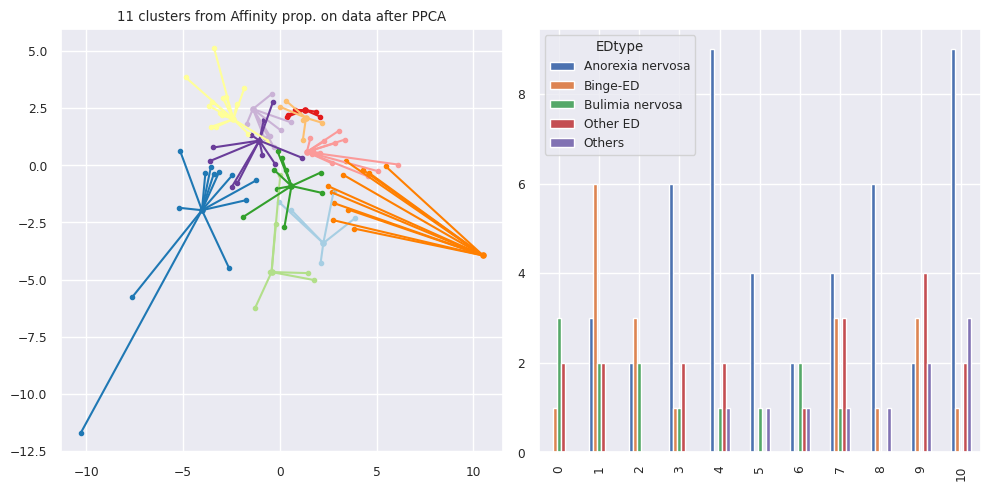

In [17]:
fig4, ax4=plt.subplots(1,2, figsize=(10,5))
colors = plt.cycler("color", plt.cm.Paired(np.linspace(0, 1, ppca_n_clusters_+1)))
cluster_median_profile, EDtype_per_cluster={},{}
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(ppca_pdist_cos, ppca_labels, metric="precomputed"))
for k, col in zip(range(ppca_n_clusters_), colors):
    class_members = ppca_labels == k
    cluster_median_profile[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    cluster_median_profile[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    cluster_median_profile[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    EDtype_per_cluster[k]=df_train_explore['EDtype'].iloc[class_members].value_counts().sort_index()
    cluster_center = component_mat[ppca_cluster_centers_indices[k]]
    ax4[0].scatter(component_mat[class_members, 0], component_mat[class_members, 1], 
                color=col["color"], marker=".")
    ax4[0].scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in component_mat[class_members]:
        ax4[0].plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

ax4[0].set_title("%d clusters from Affinity prop. on data after PPCA" % ppca_n_clusters_)
af_cluster_df=pd.DataFrame.from_dict(cluster_median_profile).T
af_cluster_df.insert(0, 'Cluster',np.array(list(range(ppca_n_clusters_)))+1)
ed_cluster_df=pd.DataFrame.from_dict(EDtype_per_cluster).T
ed_cluster_df.rename(columns={'EDtype':'Cluster'}, inplace=True)
ed_cluster_df.plot.bar(ax=ax4[1])
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_PPCA_AP_Clustering.pdf')

#### Clustering with Gaussian Mixture models

In [18]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

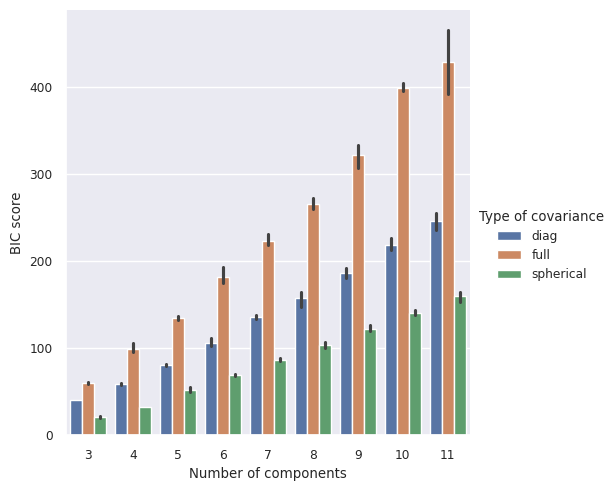

,Number of components,Type of covariance,Init params,BIC score
63,3,spherical,k-means++,19.505437
54,3,spherical,kmeans,21.606734
72,3,spherical,random_from_data,21.672178
55,4,spherical,kmeans,32.497715
73,4,spherical,random_from_data,32.652195


In [19]:
param_grid = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(evd_z_train_explore.data)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
sns.catplot(data=df, kind="bar", x="Number of components", y="BIC score", hue="Type of covariance",)
plt.show()
df.sort_values(by=["BIC score"]).head()

Silhouette Coefficient: 0.626


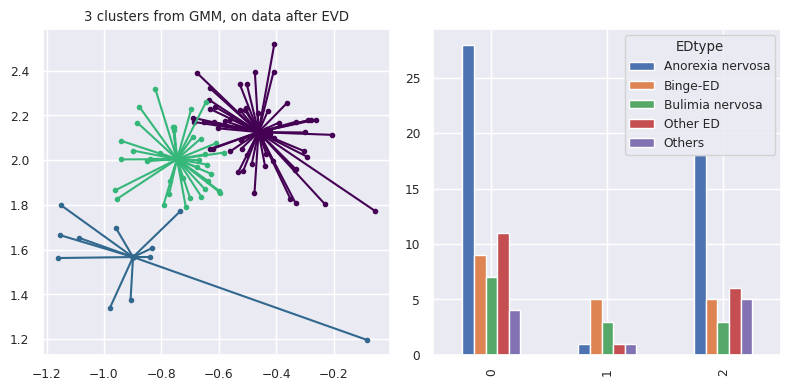

In [20]:
n_components, data_to_cluster=3, evd_z_train_explore.data
gmm_model=GaussianMixture(n_init=20, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++', random_state=11).fit(data_to_cluster)
gmm_labels=gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, gmm_labels, metric="cosine"))
gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
gmm_ED_cluster['GMMcluster']=gmm_labels
fig5, ax5=plt.subplots(1,2, figsize=(8,4))
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_components+1)))
gmm_cluster_median_profile, gmm_EDtype_per_cluster={},{}
for k, col in zip(range(n_components), colors):
    class_members = gmm_labels == k
    gmm_cluster_median_profile[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    gmm_cluster_median_profile[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    gmm_cluster_median_profile[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    gmm_EDtype_per_cluster[k]=df_train_explore['EDtype'].iloc[class_members].value_counts().sort_index()
    gmm_cluster_center = data_to_cluster[gmm_labels == k].mean(axis=0)
    ax5[0].scatter(data_to_cluster[class_members, 0], data_to_cluster[class_members, 1],color=col["color"], marker=".")
    ax5[0].scatter(gmm_cluster_center[0], gmm_cluster_center[1], s=14, color=col["color"], marker="o")
    for x in data_to_cluster[class_members]:
        ax5[0].plot([gmm_cluster_center[0], x[0]], [gmm_cluster_center[1], x[1]], color=col["color"])

ax5[0].set_title("%d clusters from GMM, on data after EVD" % n_components)
gmm_cluster_df=pd.DataFrame.from_dict(gmm_cluster_median_profile).T
gmm_cluster_df.insert(0, 'Cluster',np.array(list(range(n_components)))+1)
gmm_ED_cluster_df=pd.DataFrame.from_dict(gmm_EDtype_per_cluster).T
gmm_ED_cluster_df.rename(columns={'EDtype':'Cluster'}, inplace=True)
gmm_ED_cluster_df.plot.bar(ax=ax5[1])
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_EVD_GMM_Clustering.pdf')

In [28]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search2 = GridSearchCV(GaussianMixture(n_init=3, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(component_mat)
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
54,3,spherical,kmeans,339.149485
63,3,spherical,k-means++,340.962302
72,3,spherical,random_from_data,350.045363
55,4,spherical,kmeans,356.766038
73,4,spherical,random_from_data,360.046704


Silhouette Coefficient: 0.354


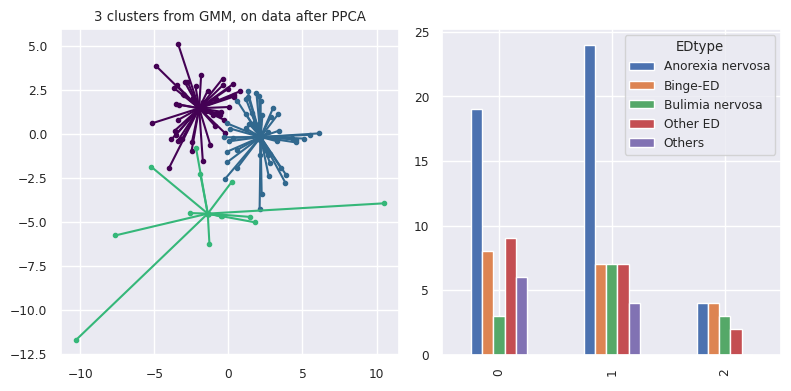

In [27]:
n_components, data_to_cluster=3, component_mat
gmm_model2=GaussianMixture(n_init=5, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans', random_state=11).fit(data_to_cluster)
gmm_labels2=gmm_model2.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, gmm_labels2, metric="cosine"))
gmm_ED_cluster2=df_train_explore[['EDtype', 'EDEQscore']].copy()
gmm_ED_cluster2['GMMcluster']=gmm_labels2
fig6, ax6=plt.subplots(1,2, figsize=(8,4))
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_components+1)))
gmm_cluster_median_profile2, gmm_EDtype_per_cluster2={},{}
for k, col in zip(range(n_components), colors):
    class_members = gmm_labels2 == k
    gmm_cluster_median_profile2[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    gmm_cluster_median_profile2[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    gmm_cluster_median_profile2[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    gmm_EDtype_per_cluster2[k]=df_train_explore['EDtype'].iloc[class_members].value_counts().sort_index()
    gmm_cluster_center2 = data_to_cluster[gmm_labels2 == k].mean(axis=0)
    ax6[0].scatter(data_to_cluster[class_members, 0], data_to_cluster[class_members, 1],color=col["color"], marker=".")
    ax6[0].scatter(gmm_cluster_center2[0], gmm_cluster_center2[1], s=14, color=col["color"], marker="o")
    for x in data_to_cluster[class_members]:
        ax6[0].plot([gmm_cluster_center2[0], x[0]], [gmm_cluster_center2[1], x[1]], color=col["color"])

ax6[0].set_title("%d clusters from GMM, on data after PPCA" % n_components)
gmm_cluster_df2=pd.DataFrame.from_dict(gmm_cluster_median_profile2).T
gmm_cluster_df2.insert(0, 'Cluster',np.array(list(range(n_components)))+1)
gmm_ED_cluster_df2=pd.DataFrame.from_dict(gmm_EDtype_per_cluster2).T
gmm_ED_cluster_df2.rename(columns={'EDtype':'Cluster'}, inplace=True)
gmm_ED_cluster_df2.plot.bar(ax=ax6[1])
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_PPCA_GMM_Clustering.pdf')

#### Agglomerative clustering

Silhouette Coefficient of 2 clusters: 0.328 (0.000)
Silhouette Coefficient of 3 clusters: 0.419 (0.000)
Silhouette Coefficient of 4 clusters: 0.370 (0.000)
Silhouette Coefficient of 5 clusters: 0.376 (0.000)
Silhouette Coefficient of 6 clusters: 0.412 (0.000)
Silhouette Coefficient of 7 clusters: 0.475 (0.000)
Silhouette Coefficient of 8 clusters: 0.488 (0.000)
Silhouette Coefficient of 9 clusters: 0.515 (0.000)
Silhouette Coefficient of 10 clusters: 0.512 (0.000)
Silhouette Coefficient of 11 clusters: 0.488 (0.000)


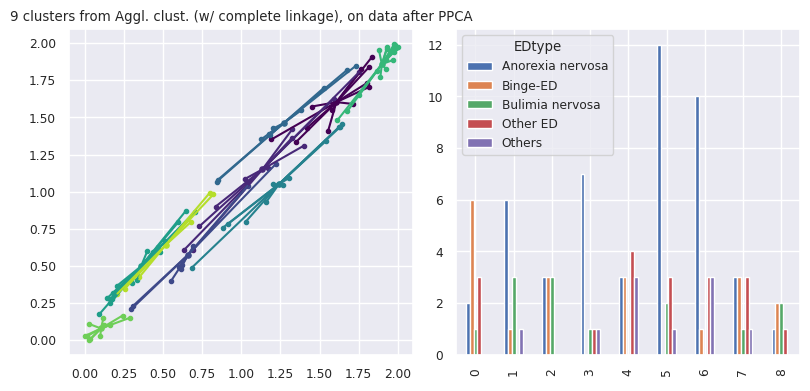

In [77]:
from sklearn.cluster import AgglomerativeClustering
data_to_cluster=ppca_pdist_cos
sill_coef=np.zeros((5,11))
for idx,n_comp in enumerate(range(2,12)):
    for iter in range(0,5):
        try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity='precomputed', linkage='complete').fit(data_to_cluster)
        sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric="precomputed")
    print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))

ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[0]+2
agg_clust=AgglomerativeClustering(n_clusters=ncomp, affinity='precomputed', linkage='complete').fit(data_to_cluster)
agg_labels=agg_clust.fit_predict(data_to_cluster)
fig7, ax7=plt.subplots(1,2, figsize=(8,4))
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, ncomp+1)))
agg_cluster_median_profile, agg_EDtype_per_cluster={},{}
for k, col in zip(range(ncomp), colors):
    class_members = agg_labels == k
    agg_cluster_median_profile[k]=df_train_explore[cols2consider].iloc[class_members].median(skipna=True)
    agg_cluster_median_profile[k]['Edu_codes']=df_train_explore['Highest_Edu'].iloc[class_members].value_counts().keys()[0]
    agg_cluster_median_profile[k]['ED_Codes']=df_train_explore['EDtype'].iloc[class_members].value_counts().keys()[0]
    agg_EDtype_per_cluster[k]=df_train_explore['EDtype'].iloc[class_members].value_counts().sort_index()
    agg_cluster_center= data_to_cluster[agg_labels == k].mean(axis=0)
    ax7[0].scatter(data_to_cluster[class_members, 0], data_to_cluster[class_members, 1],color=col["color"], marker=".")
    ax7[0].scatter(agg_cluster_center[0], agg_cluster_center[1], s=14, color=col["color"], marker="o")
    for x in data_to_cluster[class_members]:
        ax7[0].plot([agg_cluster_center[0], x[0]], [agg_cluster_center[1], x[1]], color=col["color"])

ax7[0].set_title("%d clusters from Aggl. clust. (w/ complete linkage), on data after PPCA" % ncomp)
agg_cluster_df=pd.DataFrame.from_dict(agg_cluster_median_profile).T
agg_cluster_df.insert(0, 'Cluster',np.array(list(range(ncomp)))+1)
agg_ED_cluster_df=pd.DataFrame.from_dict(agg_EDtype_per_cluster).T
agg_ED_cluster_df.rename(columns={'EDtype':'Cluster'}, inplace=True)
agg_ED_cluster_df.plot.bar(ax=ax7[1])
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_PPCA_Agglom_Clustering.pdf')

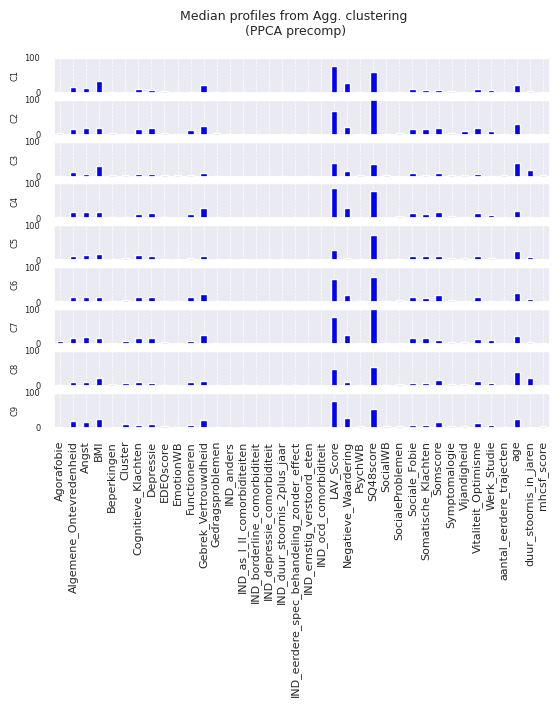

In [119]:
fig8, axes8 = plt.subplots(nrows=ncomp, ncols=1)
colnames=np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,9):
    df_temp=agg_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=axes8[nrow])
    axes8[nrow].set_ylim(0, 100)
    axes8[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    axes8[nrow].set_yticklabels(axes8[nrow].get_yticklabels(), fontsize=6)
    if nrow<8:        
        axes8[nrow].set_xticklabels('')
    else:
        axes8[nrow].set_xticklabels(colnames, fontsize=8)    
    axes8[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig8.suptitle('Median profiles from Agg. clustering\n (PPCA precomp)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_PMM_Agg_Clust_Profiles.pdf')
    #agg_cluster_df[np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])].loc[
    #agg_cluster_df['Cluster']==nrow+1].plot(ax=axes8[nrow], kind='bar')

<Axes: >

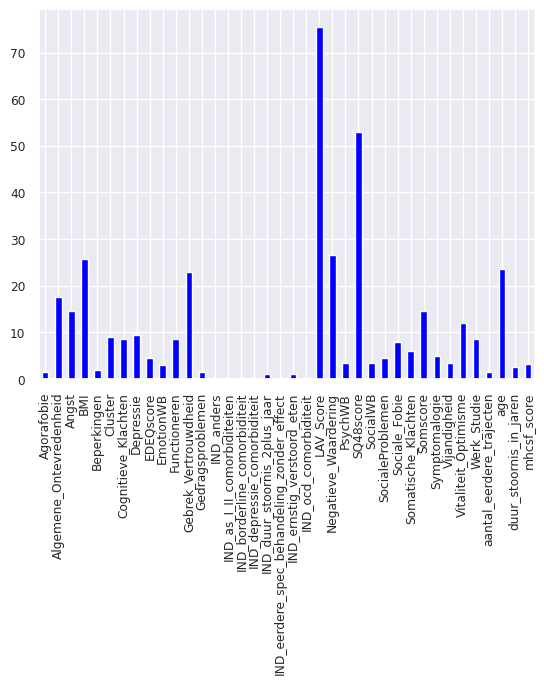

In [97]:
colnames=np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
df_temp=agg_cluster_df[np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])].iloc[nrow]
#df_temp.index=list(colnames)
df_temp.plot.bar(legend=False, color='blue', rot=90)